In [9]:
import pickle

import numpy as np

from keyrover import *
from keyrover.ml import get_device

device = get_device()
device

'mps'

In [11]:
SIZE = (256, 256)

with open("blender/camera_data.bin", "rb") as f:
    camera_data = pickle.load(f)
camera_data

{'location': [(-0.9987151622772217, -0.0966753363609314, 4.024825572967529),
  (1.2365028858184814, -1.2842673063278198, 4.5277838706970215),
  (-1.457627296447754, 0.05494561791419983, 3.087705612182617),
  (-0.0578940212726593, -0.555942177772522, 3.8600893020629883),
  (-0.7798902988433838, -0.656195878982544, 3.6948118209838867),
  (-0.7656452655792236, -1.463914155960083, 3.0741169452667236),
  (-1.296417236328125, -0.8688849210739136, 3.2211320400238037),
  (-0.17323459684848785, -1.250713586807251, 2.763913154602051),
  (1.4821281433105469, -1.4622588157653809, 3.6018972396850586),
  (-0.4543195366859436, -0.38401180505752563, 2.031959056854248),
  (-0.33115872740745544, -1.4070367813110352, 2.0791842937469482),
  (0.23276948928833008, 0.8860774040222168, 4.142958164215088),
  (-0.2289634644985199, -0.8878260254859924, 3.6943840980529785),
  (-0.049959152936935425, 0.15432646870613098, 4.142856121063232),
  (-0.4180646240711212, -0.8875488638877869, 2.1587295532226562),
  (-1.73

In [159]:
import torch


def alpha_rotation_matrix(alpha):
    """
    Rx = [[1, 0, 0],
          [0, cos(α), sin(α)],
          [0, -sin(α), cos(α)]]
    """
    cos_alpha = torch.cos(alpha)
    sin_alpha = torch.sin(alpha)

    Rx1 = torch.stack([ones, zeros, zeros], dim=1)
    Rx2 = torch.stack([zeros, cos_alpha, sin_alpha], dim=1)
    Rx3 = torch.stack([zeros, -sin_alpha, cos_alpha], dim=1)
    return torch.stack([Rx1, Rx2, Rx3], dim=1)


def beta_rotation_matrix(beta):
    """
    Ry = [[cos(β), 0, sin(β)],
          [0, 1, 0],
          [-sin(β), 0, cos(β)]]
    """
    cos_beta = torch.cos(beta)
    sin_beta = torch.sin(beta)

    Ry1 = torch.stack([cos_beta, zeros, sin_beta], dim=1)
    Ry2 = torch.stack([zeros, ones, zeros], dim=1)
    Ry3 = torch.stack([-sin_beta, zeros, cos_beta], dim=1)
    return torch.stack([Ry1, Ry2, Ry3], dim=1)


def gamma_rotation_matrix(gamma):
    """
    Rz = [[cos(γ), -sin(γ), 0],
          [sin(γ),  cos(γ), 0],
          [0,  0, 1]]
    """
    cos_gamma = torch.cos(gamma)
    sin_gamma = torch.sin(gamma)

    Rz1 = torch.stack([cos_gamma, -sin_gamma, zeros], dim=1)
    Rz2 = torch.stack([sin_gamma, cos_gamma, zeros], dim=1)
    Rz3 = torch.stack([zeros, zeros, ones], dim=1)
    return torch.stack([Rz1, Rz2, Rz3], dim=1)


def rotation_matrix(alpha, beta, gamma):
    """
    R = Rx @ Ry @ Rz
    """
    Rx = alpha_rotation_matrix(alpha)
    Ry = beta_rotation_matrix(beta)
    Rz = gamma_rotation_matrix(gamma)

    return Rz @ Ry @ Rx


def extrinsic_matrix(alpha, beta, gamma, position):
    """
    position = [x, y, z]
    
    E = [R | -R @ position]
    """
    R = rotation_matrix(alpha, beta, gamma)
    position = position.unsqueeze(axis=-1)
    return torch.concat([R, R @ position], dim=-1)


def intrinsic_matrix(fx, fy, cx, cy):
    """
    K = [[fx, 0, cx],
         [0, fy, cy],
         [0,  0,  1]]
    """
    K1 = torch.stack([fx, zeros, cx], dim=1)
    K2 = torch.stack([zeros, fy, cy], dim=1)
    K3 = torch.stack([zeros, zeros, ones], dim=1)
    return torch.stack([K1, K2, K3], dim=1)


def projection_matrix(alpha, beta, gamma, position):
    """
    P = K @ E
    """
    E = extrinsic_matrix(alpha, beta, gamma, position)
    return K @ E


def prediction_to_projection_matrix(pred):
    global ones, zeros

    batch_size = len(pred)
    ones = torch.ones(batch_size, dtype=torch.float32, device=device)
    zeros = torch.zeros(batch_size, dtype=torch.float32, device=device)

    alpha = pred[:, 0]
    beta = pred[:, 1]
    gamma = pred[:, 2]
    position = pred[:, 3:]

    return projection_matrix(alpha, beta, gamma, position)


def project_point(P, v):
    """
    [x', y', z'] = P @ [x, y, 1]
    return [x' / z', y' / z']
    """
    v = P @ v
    return (v[:, :2] / v[:, -1:]).T


def prediction_to_corners(pred):
    P = prediction_to_projection_matrix(pred)

    return (project_point(P, P1),
            project_point(P, P2),
            project_point(P, P3),
            project_point(P, P4))


def xy_to_uv_matrix(p1, p2, p3, p4):
    """
    M = [[x1, x2, x3],
         [y1, y2, y3],
         [ 1,  1,  1]]
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    M1 = torch.stack([x1, x2, x3], dim=1)
    M2 = torch.stack([y1, y2, y3], dim=1)
    M3 = torch.stack([ones, ones, ones], dim=1)
    M = torch.stack((M1, M2, M3), dim=1)

    M_inv = torch.inverse(M)

    """
    X = [x4, y4, 1]
    """
    X = torch.stack([x4, y4, ones], dim=1)
    X = X.unsqueeze(dim=-1)

    """
    H = M @ X = [λ, μ, τ]
    """
    H = M_inv @ X
    H = H.squeeze(dim=-1)

    """
    A = [[λ * x1, μ * x2, τ * x3],
         [λ * y1, μ * y2, τ * y3],
         [     λ,      μ,     τ]]
    """
    A = torch.einsum('bij, bj -> bij', M, H)
    A_inv = torch.inverse(A)

    """
    C = B @ A_inv
    [x', y', z'] = C @ [x, y, 1]
    result = [x' / z', y' / z']
    
    only keep values between 0 & 255, zero-out the rest
    """
    return B @ A_inv


def prediction_to_texture_coordinates(pred):
    C = xy_to_uv_matrix(*prediction_to_corners(pred))

    """
    [u, v, z] = C @ [x, y, 1]
    result = [u / z, y / z]
    """
    result = torch.einsum('bij, yxj -> byxi', C, coordinates)
    result = result[:, :, :, :3] / result[:, :, :, -1:]

    # filter any points outside the keyboard
    result[(result.max(axis=-1)[0] > 255)] = 0
    result[result.min(axis=-1)[0] < 0] = 0

    # reorder dimensions from (batch, y, x, channel) to (batch, channel, y, x)
    result = torch.einsum('byxc -> bcyx', result)
    return (result / 128) - 1


def xy_to_uv_change_of_basis_matrix():
    """
    M = [[x1, x2, x3],
         [y1, y2, y3],
         [ 1,  1,  1]]
         
    X = [x4, y4, 1]
    """
    M = np.array([[0, 255, 255],
                  [0, 0, 255],
                  [1, 1, 1]])
    M_inv = np.linalg.inv(M)

    X = np.array([0, 255, 1])

    """
    H = M @ X = [λ, μ, τ]
    """
    H = M_inv @ X

    """
    B = [[λ * x1, μ * x2, τ * x3],
         [λ * y1, μ * y2, τ * y3],
         [     λ,      μ,     τ]]
    """
    return torch.tensor(M * H, dtype=torch.float32, device=device)


def color_coordinates_mesh():
    x = np.linspace(0, 255, SIZE[0])
    y = np.linspace(0, 255, SIZE[1])
    xx, yy = np.meshgrid(x, y)
    one = np.ones(xx.shape)

    mesh = np.stack((xx, yy, one), axis=-1)
    return torch.tensor(mesh, dtype=torch.float32, device=device)


B = xy_to_uv_change_of_basis_matrix()

FX = 190
FY = 190
K = torch.tensor([[FX, 0, FX / 2],
                  [0, FY, FY / 2],
                  [0, 0, 1]], dtype=torch.float32, device=device)

width = 2.928
height = 1

coordinates = color_coordinates_mesh()

X = -0.21919
Y = -0.0818
Z = -0.13053

P3 = torch.tensor([width + X, -height + Y, Z, 1], dtype=torch.float32, device=device)
P2 = torch.tensor([width + X, height + Y, Z, 1], dtype=torch.float32, device=device)
P1 = torch.tensor([-width + X, height + Y, Z, 1], dtype=torch.float32, device=device)
P4 = torch.tensor([-width + X, -height + Y, Z, 1], dtype=torch.float32, device=device)

In [160]:
from math import degrees

i = 1
location = camera_data["location"][i]
rotation = camera_data["rotation"][i]

print("Location:", location)
print("Rotation (rad):", rotation)
print("Rotation (°):", tuple(map(degrees, rotation)))

Location: (1.2365028858184814, -1.2842673063278198, 4.5277838706970215)
Rotation (rad): (0.26814863085746765, -0.005352634936571121, 0.39659300446510315)
Rotation (°): (15.36378483034437, -0.30668339113980037, 22.723105340263423)


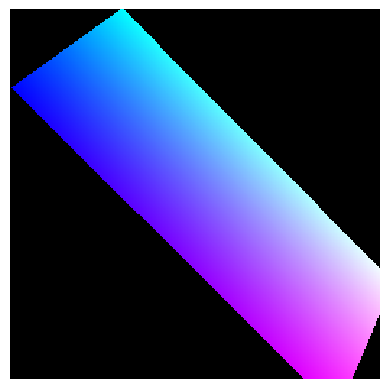

In [170]:
i = 8
location = camera_data["location"][i]
rotation = camera_data["rotation"][i]

# prediction format: [[alpha, beta, gamma, x, y, z], ... (batches)]
prediction = torch.tensor([[*rotation, *location]],
                          requires_grad=True, device=device, dtype=torch.float32)

texcoords = prediction_to_texture_coordinates(prediction)

t = texcoords[0]
t[2] += 1
t[2] /= t[2].max() / 2
t[2] -= 1

imshow(t)